In [40]:
import torch

# Target norm
target = torch.tensor(5.0)

# Trainable parameter a
a = torch.nn.Parameter(torch.tensor(0.0))

# Fixed part of the vector
v_1_1 = torch.tensor([1.0, 1.0])  # shape: (2,)

# Fixed vector to cross with
v2 = torch.tensor([2.0, 1.0, 1.0])  # shape: (3,)

# Optimizer
optimizer = torch.optim.SGD([a], lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()

    # Combine a and v_1_1 to form v1
    v1 = torch.cat([a.view(1), v_1_1])  # shape: (3,)

    # Compute cross product
    cross = torch.cross(v1, v2)

    # Compute norm
    norm = torch.norm(cross)

    # Loss function: squared error
    loss = (norm - target) ** 2

    # Backprop and optimization
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: a = {a.item():.4f}, norm = {norm.item():.4f}, loss = {loss.item():.6f}")

print(f"\nFinal value of a: {a.item():.4f}")


Epoch 0: a = -0.0614, norm = 2.8284, loss = 4.715729
Epoch 10: a = -0.5555, norm = 3.5563, loss = 2.084364
Epoch 20: a = -0.8840, norm = 4.0402, loss = 0.921294
Epoch 30: a = -1.1024, norm = 4.3619, loss = 0.407214
Epoch 40: a = -1.2475, norm = 4.5757, loss = 0.179990
Epoch 50: a = -1.3441, norm = 4.7179, loss = 0.079556
Epoch 60: a = -1.4082, norm = 4.8125, loss = 0.035164
Epoch 70: a = -1.4509, norm = 4.8753, loss = 0.015543
Epoch 80: a = -1.4793, norm = 4.9171, loss = 0.006870
Epoch 90: a = -1.4981, norm = 4.9449, loss = 0.003036

Final value of a: -1.5096


In [41]:
import torch

# v1 is a dict
v1 = {
    "1": torch.tensor([0.0, 1.0,1.0], requires_grad=True)  # We will overwrite v1["1"][0] with `a` each iteration
}

# Target norm
target = torch.tensor(5.0)

# Trainable parameter a (1-element tensor)
a = torch.nn.Parameter(torch.tensor(0.0))

# Fixed part of the vector
v1_rest = torch.tensor([1.0, 1.0])  # The fixed second and third components

# Fixed vector to cross with
v2 = torch.tensor([2.0, 1.0, 1.0])  # shape: (3,)

# Optimizer
optimizer = torch.optim.SGD([a], lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()

    # Dynamically create v1 with current a
    v1["1"] = torch.cat([a.view(1), v1_rest])  # shape: (3,)

    # Compute cross product
    cross = torch.cross( v1["1"], v2)

    # Compute norm
    norm = torch.norm(cross)

    # Loss function: squared error
    loss = (norm - target) ** 2

    # Backprop and optimization
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: a = {a.item():.4f}, norm = {norm.item():.4f}, loss = {loss.item():.6f}")

print(f"\nFinal value of a: {a.item():.4f}")



Epoch 0: a = -0.0614, norm = 2.8284, loss = 4.715729
Epoch 10: a = -0.5555, norm = 3.5563, loss = 2.084364
Epoch 20: a = -0.8840, norm = 4.0402, loss = 0.921294
Epoch 30: a = -1.1024, norm = 4.3619, loss = 0.407214
Epoch 40: a = -1.2475, norm = 4.5757, loss = 0.179990
Epoch 50: a = -1.3441, norm = 4.7179, loss = 0.079556
Epoch 60: a = -1.4082, norm = 4.8125, loss = 0.035164
Epoch 70: a = -1.4509, norm = 4.8753, loss = 0.015543
Epoch 80: a = -1.4793, norm = 4.9171, loss = 0.006870
Epoch 90: a = -1.4981, norm = 4.9449, loss = 0.003036

Final value of a: -1.5096


In [42]:
import torch

# Fixed vector (no grad)
fixed = torch.tensor([2.0, 3.0, 4.0], requires_grad=False)

# Trainable scalar param
param = torch.nn.Parameter(torch.tensor(1.0))

# Compose new vector
new_vec = torch.cat([param.view(1), fixed[1:]])

print("New vector:", new_vec)

# Dummy scalar function of new_vec (e.g. sum of squares)
loss = (new_vec ** 2).sum()

loss.backward()

print("Gradient of param:", param.grad)  # Should be nonzero: 2 * param = 2.0


New vector: tensor([1., 3., 4.], grad_fn=<CatBackward0>)
Gradient of param: tensor(2.)


Geometry: Geometry(OH2)
OrbitalInfo: <tbmalt.structures.orbitalinfo.OrbitalInfo object at 0x7f02c58504d0>
H on-site parameters: Parameter containing:
tensor([-4.7711e-01,  3.9000e-05,  3.9000e-05,  3.9000e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       requires_grad=True)
O on-site parameters: Parameter containing:
tensor([-0.7317, -0.0576, -0.0576, -0.0576,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000], requires_grad=True)
Epoch 0, Loss: 1.511787
H on-site parameters: Parameter containing:
tensor([-4.7711e-01,  3.9000e-05,  3.9000e-05,  3.9000e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       requires_grad=True)
O on-site parameters: Parameter containing:
tensor([-0.7317, -0.0576, -0.0576, -0.0576,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000], requires_grad=True)
H on-site parameters: Parameter containing:
tensor([-4.7711e-01,  3.9000e-05,  3.9000e-05,  3.9000e-05,  0.0000e+00,
         0.0000e+00

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

H on-site parameters: Parameter containing:
tensor([-4.7711e-01,  3.9000e-05,  3.9000e-05,  3.9000e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       requires_grad=True)
O on-site parameters: Parameter containing:
tensor([-0.7317, -0.0576, -0.0576, -0.0576,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000], requires_grad=True)
H on-site parameters: Parameter containing:
tensor([-4.7711e-01,  3.9000e-05,  3.9000e-05,  3.9000e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       requires_grad=True)
O on-site parameters: Parameter containing:
tensor([-0.7317, -0.0576, -0.0576, -0.0576,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000], requires_grad=True)
H on-site parameters: Parameter containing:
tensor([-4.7711e-01,  3.9000e-05,  3.9000e-05,  3.9000e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       requires_grad=True)
O on-site parameters: Parameter containing:
tensor([-0.7317, 

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


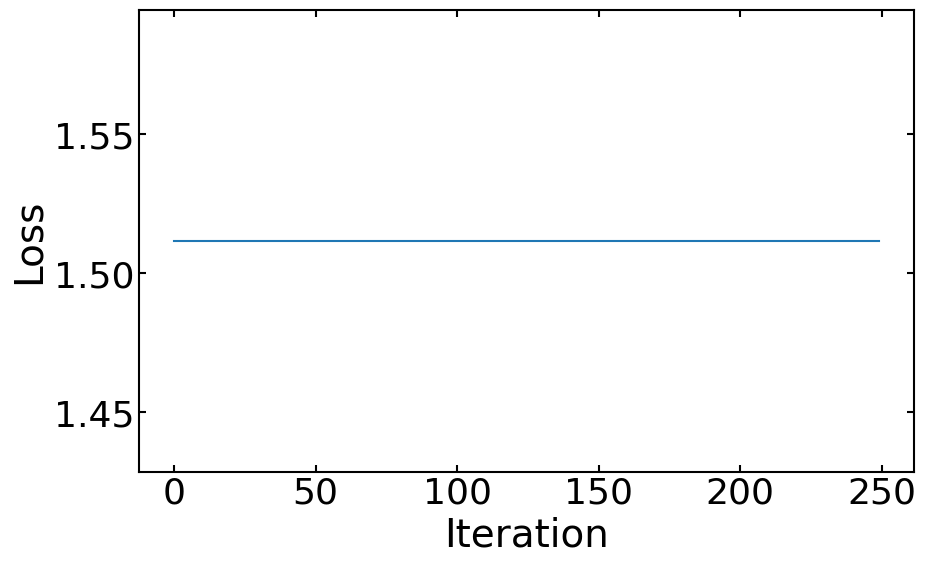

In [43]:
import torch
from tbmalt import Geometry, OrbitalInfo
from tbmalt.physics.dftb import Dftb2
from tbmalt.physics.dftb.feeds import SkFeed, SkfOccupationFeed, HubbardFeed, RepulsiveSplineFeed
from tbmalt.common.maths.interpolation import CubicSpline
from tbmalt.ml.loss_function import Loss, mse_loss
import torch.nn as nn

# This must be set until typecasting from HDF5 databases has been implemented.
torch.set_default_dtype(torch.float64)

# Reference of target properties
targets = {'total_energy': torch.tensor([-4.0779]),
           'q_final_atomic': torch.tensor([6.5926, 0.7037, 0.7037])}

# Provide information about the orbitals on each atom
shell_dict = {1: [0], 6: [0, 1], 7: [0, 1], 8: [0, 1]}

# Location at which the DFTB parameter set database is located
parameter_db_path = 'mio.h5'

# Training hyperparameters
number_of_epochs = 250
lr = 0.02

device = torch.device('cpu')

# Construct the Geometry and OrbitalInfo objects
geometry = Geometry(
        torch.tensor([8,1,1], device=device),
        torch.tensor([
            [0.00000000, -0.71603315, -0.00000000],
            [0.00000000, -0.14200298, 0.77844804 ],
            [-0.00000000, -0.14200298, -0.77844804]],
            device=device), units='a')

orbs = OrbitalInfo(geometry.atomic_numbers, shell_dict)

print('Geometry:', geometry)
print('OrbitalInfo:', orbs)

# Identify which species are present
species = torch.unique(geometry.atomic_numbers)
species = species[species != 0].tolist()

# Load all the necessary feed models
h_feed = SkFeed.from_database(parameter_db_path, species, 'hamiltonian',
                              interpolation=CubicSpline, requires_grad_onsite=True)
s_feed = SkFeed.from_database(parameter_db_path, species, 'overlap',
                              interpolation=CubicSpline)
o_feed = SkfOccupationFeed.from_database(parameter_db_path, species)
u_feed = HubbardFeed.from_database(parameter_db_path, species)
r_feed = RepulsiveSplineFeed.from_database(parameter_db_path, species)


slice_h = torch.tensor([3.9000e-05, 3.9000e-05, 3.9000e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64)
slice_o = torch.tensor([0., 0., 0., 0., 0.], dtype=torch.float64)

torch.manual_seed(4)  # Set random seed for reproducibility

# Create 3 individual trainable parameters
h_param = nn.Parameter(-torch.rand(1, dtype=torch.double))      # For H on-site[0]
o_param_a = nn.Parameter(-torch.rand(1, dtype=torch.double))    # For O on-site[0]
o_param_b = nn.Parameter(-torch.rand(1, dtype=torch.double))    # For O on-site[1:4]

# Get the 3 specific parameters for optimization
params = [h_param,o_param_a,o_param_b]

# Create the DFTB calculator
dftb_calculator = Dftb2(h_feed, s_feed, o_feed, u_feed, r_feed, filling_scheme=None)

# Define optimizer with the parameters
optimizer = torch.optim.Adam(params, lr=lr)

# Training loop
loss_list = []
for epoch in range(number_of_epochs):
    optimizer.zero_grad()

    # Create parameters directly in the on_sites dictionaries
    # For hydrogen (Z=1)
    h_feed._on_sites["1"]= torch.cat([h_param.view(1), slice_h])  # x parameter

    # For oxygen (Z=8)
    h_feed._on_sites["8"]= torch.cat([o_param_a.view(1),o_param_b.view(1).repeat(3),slice_o])  # a parameter 

    print("H on-site parameters:", h_feed._on_sites["1"])
    print("O on-site parameters:", h_feed._on_sites["8"])
   
    # Run DFTB calculation
    dftb_calculator(geometry, orbs, grad_mode="direct")
    
    # Calculate loss
    energy_loss = mse_loss(dftb_calculator.total_energy, targets['total_energy'])
    mulliken_loss = mse_loss(dftb_calculator.q_final_atomic, targets['q_final_atomic'])
    loss = energy_loss + mulliken_loss
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Record loss
    loss_list.append(loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

# Print final parameters

print("Original H on-site parameters:", original_h)
print("Original O on-site parameters:", original_o)

print(f"Final H on-site parameters: {h_feed._on_sites['1']}")
print(f"Final O on-site parameters: {h_feed._on_sites['8']}")

# Plot the loss
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.linewidth"] = 1.5
plt.tick_params(direction='in', labelsize='26', width=1.5, length=5, top='on',
                right='on', zorder=10)
plt.plot(range(number_of_epochs), loss_list)
plt.xlabel("Iteration", fontsize=28)
plt.ylabel("Loss", fontsize=28)
plt.show()

DFTB MACHINE LEARNING DEBUG SCRIPT
Target total energy: tensor([-4.0779])
Target atomic charges: tensor([6.5926, 0.7037, 0.7037])
Targets require grad: Energy=False, Charges=False
Device: cpu

Geometry object:
  Atomic numbers: tensor([8, 1, 1])
  Positions shape: torch.Size([3, 3])
  Atomic numbers require grad: False
  Positions require grad: False
  Geometry on device: cpu

OrbitalInfo object:
  Shell dict: {1: [0], 6: [0, 1], 7: [0, 1], 8: [0, 1]}
  Orbs object type: <class 'tbmalt.structures.orbitalinfo.OrbitalInfo'>

Species present: [1, 8]

LOADING FEED MODELS
Feed models loaded successfully!

Hamiltonian feed type: <class 'tbmalt.physics.dftb.feeds.SkFeed'>
Hamiltonian feed has _on_sites: True
H feed _on_sites keys: ['1', '8']
  1: shape=torch.Size([9]), requires_grad=True
  8: shape=torch.Size([9]), requires_grad=True

Overlap feed type: <class 'tbmalt.physics.dftb.feeds.SkFeed'>
Occupation feed type: <class 'tbmalt.physics.dftb.feeds.SkfOccupationFeed'>
Hubbard feed type: <cl

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f


FINAL RESULTS
Original H on-site parameters: Parameter containing:
tensor([-2.3860e-01,  3.9000e-05,  3.9000e-05,  3.9000e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       requires_grad=True)
Original O on-site parameters: Parameter containing:
tensor([-0.8788, -0.3321, -0.3321, -0.3321,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000], requires_grad=True)
Final H on-site parameters: Parameter containing:
tensor([-4.7711e-01,  3.9000e-05,  3.9000e-05,  3.9000e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       requires_grad=True)
Final O on-site parameters: Parameter containing:
tensor([-0.7317, -0.0576, -0.0576, -0.0576,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000], requires_grad=True)
Final trainable parameters:
  h_param: Parameter containing:
tensor([-0.4771], requires_grad=True)
  o_param_a: Parameter containing:
tensor([-0.7317], requires_grad=True)
  o_param_b: Parameter containing:
tensor([-0.057

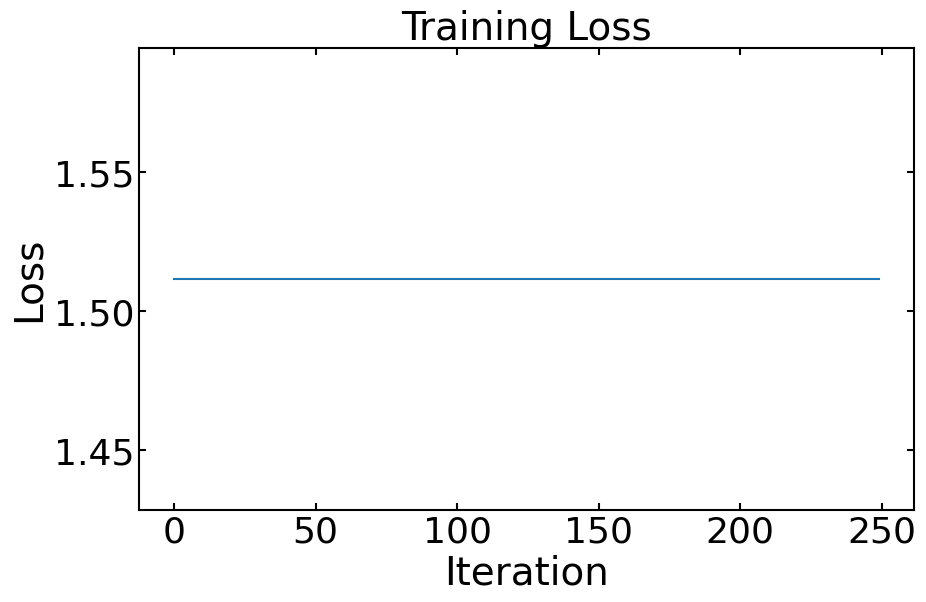

Loss plot created successfully!

DEBUG SCRIPT COMPLETED


In [ ]:
import torch
from tbmalt import Geometry, OrbitalInfo
from tbmalt.physics.dftb import Dftb2
from tbmalt.physics.dftb.feeds import SkFeed, SkfOccupationFeed, HubbardFeed, RepulsiveSplineFeed
from tbmalt.common.maths.interpolation import CubicSpline
from tbmalt.ml.loss_function import Loss, mse_loss
import torch.nn as nn

# This must be set until typecasting from HDF5 databases has been implemented.
torch.set_default_dtype(torch.float64)

print("=" * 80)
print("DFTB MACHINE LEARNING DEBUG SCRIPT")
print("=" * 80)

# Reference of target properties
targets = {'total_energy': torch.tensor([-4.0779]),
           'q_final_atomic': torch.tensor([6.5926, 0.7037, 0.7037])}

print(f"Target total energy: {targets['total_energy']}")
print(f"Target atomic charges: {targets['q_final_atomic']}")
print(f"Targets require grad: Energy={targets['total_energy'].requires_grad}, Charges={targets['q_final_atomic'].requires_grad}")

# Provide information about the orbitals on each atom
shell_dict = {1: [0], 6: [0, 1], 7: [0, 1], 8: [0, 1]}

# Location at which the DFTB parameter set database is located
parameter_db_path = 'mio.h5'

# Training hyperparameters
number_of_epochs = 250
lr = 0.02

device = torch.device('cpu')
print(f"Device: {device}")

# Construct the Geometry and OrbitalInfo objects
geometry = Geometry(
        torch.tensor([8,1,1], device=device),
        torch.tensor([
            [0.00000000, -0.71603315, -0.00000000],
            [0.00000000, -0.14200298, 0.77844804 ],
            [-0.00000000, -0.14200298, -0.77844804]],
            device=device), units='a')

orbs = OrbitalInfo(geometry.atomic_numbers, shell_dict)

print('\nGeometry object:')
print(f'  Atomic numbers: {geometry.atomic_numbers}')
print(f'  Positions shape: {geometry.positions.shape}')
print(f'  Atomic numbers require grad: {geometry.atomic_numbers.requires_grad}')
print(f'  Positions require grad: {geometry.positions.requires_grad}')
print(f'  Geometry on device: {geometry.atomic_numbers.device}')

print('\nOrbitalInfo object:')
print(f'  Shell dict: {shell_dict}')
print(f'  Orbs object type: {type(orbs)}')

# Identify which species are present
species = torch.unique(geometry.atomic_numbers)
species = species[species != 0].tolist()
print(f'\nSpecies present: {species}')

# Load all the necessary feed models
print("\n" + "="*50)
print("LOADING FEED MODELS")
print("="*50)

h_feed = SkFeed.from_database(parameter_db_path, species, 'hamiltonian',
                              interpolation=CubicSpline, requires_grad_onsite=True)
s_feed = SkFeed.from_database(parameter_db_path, species, 'overlap',
                              interpolation=CubicSpline)
o_feed = SkfOccupationFeed.from_database(parameter_db_path, species)
u_feed = HubbardFeed.from_database(parameter_db_path, species)
r_feed = RepulsiveSplineFeed.from_database(parameter_db_path, species)

print("Feed models loaded successfully!")

# Check feed properties
print(f"\nHamiltonian feed type: {type(h_feed)}")
print(f"Hamiltonian feed has _on_sites: {hasattr(h_feed, '_on_sites')}")
if hasattr(h_feed, '_on_sites'):
    print(f"H feed _on_sites keys: {list(h_feed._on_sites.keys()) if h_feed._on_sites else 'None'}")
    if h_feed._on_sites:
        for key, value in h_feed._on_sites.items():
            print(f"  {key}: shape={value.shape if hasattr(value, 'shape') else 'no shape'}, requires_grad={value.requires_grad if hasattr(value, 'requires_grad') else 'no grad'}")

print(f"\nOverlap feed type: {type(s_feed)}")
print(f"Occupation feed type: {type(o_feed)}")
print(f"Hubbard feed type: {type(u_feed)}")
print(f"Repulsive feed type: {type(r_feed)}")

# Store original parameters for comparison
print("\n" + "="*50)
print("ORIGINAL PARAMETERS")
print("="*50)

if hasattr(h_feed, '_on_sites') and h_feed._on_sites:
    original_h = h_feed._on_sites.get("1", None)
    original_o = h_feed._on_sites.get("8", None)
    print(f"Original H on-site parameters: {original_h}")
    print(f"Original O on-site parameters: {original_o}")
    if original_h is not None:
        print(f"Original H requires_grad: {original_h.requires_grad}")
    if original_o is not None:
        print(f"Original O requires_grad: {original_o.requires_grad}")
else:
    print("No original _on_sites found in h_feed")
    original_h = None
    original_o = None

slice_h = torch.tensor([3.9000e-05, 3.9000e-05, 3.9000e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64)
slice_o = torch.tensor([0., 0., 0., 0., 0.], dtype=torch.float64)

print(f"\nSlice H: {slice_h}")
print(f"Slice O: {slice_o}")
print(f"Slice H requires_grad: {slice_h.requires_grad}")
print(f"Slice O requires_grad: {slice_o.requires_grad}")

torch.manual_seed(4)  # Set random seed for reproducibility

# Create 3 individual trainable parameters
print("\n" + "="*50)
print("CREATING TRAINABLE PARAMETERS")
print("="*50)

h_param = nn.Parameter(-torch.rand(1, dtype=torch.double))      # For H on-site[0]
o_param_a = nn.Parameter(-torch.rand(1, dtype=torch.double))    # For O on-site[0]
o_param_b = nn.Parameter(-torch.rand(1, dtype=torch.double))    # For O on-site[1:4]

print(f"H parameter: {h_param}")
print(f"O parameter A: {o_param_a}")
print(f"O parameter B: {o_param_b}")
print(f"H parameter requires_grad: {h_param.requires_grad}")
print(f"O parameter A requires_grad: {o_param_a.requires_grad}")
print(f"O parameter B requires_grad: {o_param_b.requires_grad}")
print(f"H parameter type: {type(h_param)}")
print(f"O parameter A type: {type(o_param_a)}")
print(f"O parameter B type: {type(o_param_b)}")

# Get the 3 specific parameters for optimization
params = [h_param, o_param_a, o_param_b]
print(f"\nOptimization parameters list: {len(params)} parameters")
for i, p in enumerate(params):
    print(f"  Param {i}: shape={p.shape}, requires_grad={p.requires_grad}, device={p.device}")

# Create the DFTB calculator
print("\n" + "="*50)
print("CREATING DFTB CALCULATOR")
print("="*50)

dftb_calculator = Dftb2(h_feed, s_feed, o_feed, u_feed, r_feed, filling_scheme=None)
print(f"DFTB calculator created: {type(dftb_calculator)}")
print(f"DFTB calculator attributes: {[attr for attr in dir(dftb_calculator) if not attr.startswith('_')]}")

# Define optimizer with the parameters
optimizer = torch.optim.Adam(params, lr=lr)
print(f"\nOptimizer created: {type(optimizer)}")
print(f"Optimizer state dict keys: {list(optimizer.state_dict().keys())}")

# Training loop with detailed debugging
print("\n" + "="*60)
print("STARTING TRAINING LOOP WITH DETAILED DEBUG INFO")
print("="*60)

loss_list = []
for epoch in range(min(5, number_of_epochs)):  # Only run first 5 epochs for debugging
    print(f"\n--- EPOCH {epoch} ---")
    
    optimizer.zero_grad()
    print("Gradients zeroed")

    # Create parameters directly in the on_sites dictionaries
    print("\nUpdating on-site parameters:")
    
    # For hydrogen (Z=1)
    h_combined = torch.cat([h_param.view(1), slice_h])
    h_feed._on_sites["1"] = h_combined
    print(f"H on-site combined shape: {h_combined.shape}")
    print(f"H on-site combined requires_grad: {h_combined.requires_grad}")
    print(f"H on-site parameters: {h_feed._on_sites['1']}")

    # For oxygen (Z=8)
    o_combined = torch.cat([o_param_a.view(1), o_param_b.view(1).repeat(3), slice_o])
    h_feed._on_sites["8"] = o_combined
    print(f"O on-site combined shape: {o_combined.shape}")
    print(f"O on-site combined requires_grad: {o_combined.requires_grad}")
    print(f"O on-site parameters: {h_feed._on_sites['8']}")
   
    # Check gradients before calculation
    print(f"\nBefore DFTB calculation:")
    print(f"  h_param.grad: {h_param.grad}")
    print(f"  o_param_a.grad: {o_param_a.grad}")
    print(f"  o_param_b.grad: {o_param_b.grad}")
    
    # Run DFTB calculation
    print("\nRunning DFTB calculation...")
    try:
        result = dftb_calculator(geometry, orbs, grad_mode="direct")
        print("DFTB calculation successful!")
        print(f"Calculator result type: {type(result)}")
        
        # Check if calculator has the expected attributes
        print(f"Calculator has total_energy: {hasattr(dftb_calculator, 'total_energy')}")
        print(f"Calculator has q_final_atomic: {hasattr(dftb_calculator, 'q_final_atomic')}")
        
        if hasattr(dftb_calculator, 'total_energy'):
            print(f"Total energy: {dftb_calculator.total_energy}")
            print(f"Total energy shape: {dftb_calculator.total_energy.shape}")
            print(f"Total energy requires_grad: {dftb_calculator.total_energy.requires_grad}")
            
        if hasattr(dftb_calculator, 'q_final_atomic'):
            print(f"Atomic charges: {dftb_calculator.q_final_atomic}")
            print(f"Atomic charges shape: {dftb_calculator.q_final_atomic.shape}")
            print(f"Atomic charges requires_grad: {dftb_calculator.q_final_atomic.requires_grad}")
        
    except Exception as e:
        print(f"DFTB calculation failed: {e}")
        break
    
    # Calculate loss
    print("\nCalculating loss...")
    try:
        energy_loss = mse_loss(dftb_calculator.total_energy, targets['total_energy'])
        mulliken_loss = mse_loss(dftb_calculator.q_final_atomic, targets['q_final_atomic'])
        loss = energy_loss + mulliken_loss
        
        print(f"Energy loss: {energy_loss}")
        print(f"Mulliken loss: {mulliken_loss}")
        print(f"Total loss: {loss}")
        print(f"Energy loss requires_grad: {energy_loss.requires_grad}")
        print(f"Mulliken loss requires_grad: {mulliken_loss.requires_grad}")
        print(f"Total loss requires_grad: {loss.requires_grad}")
        
    except Exception as e:
        print(f"Loss calculation failed: {e}")
        break
    
    # Backward pass
    print("\nPerforming backward pass...")
    try:
        loss.backward()
        print("Backward pass successful!")
        
        # Check gradients after backward pass
        print(f"After backward pass:")
        print(f"  h_param.grad: {h_param.grad}")
        print(f"  o_param_a.grad: {o_param_a.grad}")
        print(f"  o_param_b.grad: {o_param_b.grad}")
        
    except Exception as e:
        print(f"Backward pass failed: {e}")
        break
    
    # Update parameters
    print("\nUpdating parameters...")
    try:
        optimizer.step()
        print("Parameter update successful!")
        
        print(f"Updated parameters:")
        print(f"  h_param: {h_param}")
        print(f"  o_param_a: {o_param_a}")
        print(f"  o_param_b: {o_param_b}")
        
    except Exception as e:
        print(f"Parameter update failed: {e}")
        break
    
    # Record loss
    loss_list.append(loss.item())
    
    print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

# Continue with full training if debugging was successful
if len(loss_list) >= 5:  # If we made it through the first 5 epochs
    print("\n" + "="*60)
    print("CONTINUING WITH FULL TRAINING")
    print("="*60)
    
    for epoch in range(5, number_of_epochs):

        # Create parameters directly in the on_sites dictionaries
        h_feed.on_sites["1"] = torch.cat([h_param.view(1), slice_h])
        h_feed.on_sites["8"] = torch.cat([o_param_a.view(1), o_param_b.view(1).repeat(3), slice_o])
       
        # Run DFTB calculation
        dftb_calculator(geometry, orbs, grad_mode="direct")
        
        # Calculate loss
        energy_loss = mse_loss(dftb_calculator.total_energy, targets['total_energy'])
        mulliken_loss = mse_loss(dftb_calculator.q_final_atomic, targets['q_final_atomic'])
        loss = energy_loss + mulliken_loss
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Record loss
        loss_list.append(loss.item())
        
        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

# Print final results
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)

if original_h is not None:
    print(f"Original H on-site parameters: {original_h}")
if original_o is not None:
    print(f"Original O on-site parameters: {original_o}")

print(f"Final H on-site parameters: {h_feed._on_sites['1']}")
print(f"Final O on-site parameters: {h_feed._on_sites['8']}")

print(f"Final trainable parameters:")
print(f"  h_param: {h_param}")
print(f"  o_param_a: {o_param_a}")
print(f"  o_param_b: {o_param_b}")

print(f"\nTraining completed with {len(loss_list)} epochs")
print(f"Final loss: {loss_list[-1] if loss_list else 'No loss recorded'}")

# Plot the loss
try:
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (10, 6)
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["axes.linewidth"] = 1.5
    plt.tick_params(direction='in', labelsize='26', width=1.5, length=5, top='on',
                    right='on', zorder=10)
    plt.plot(range(len(loss_list)), loss_list)
    plt.xlabel("Iteration", fontsize=28)
    plt.ylabel("Loss", fontsize=28)
    plt.title("Training Loss", fontsize=28)
    plt.show()
    print("Loss plot created successfully!")
except Exception as e:
    print(f"Could not create plot: {e}")

print("\n" + "="*80)
print("DEBUG SCRIPT COMPLETED")
print("="*80)